<a href="https://colab.research.google.com/github/mharrisonbaker/samplework/blob/master/classifier_and_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challege 1: Patent Classification problem

Build a model to predict CPC class - In the first challenge, you are expected to develop a patent classifier for CPC class prediction. For this challenge, we are only interested in classifying patents into CPC sections (first letter only).

## Load libraries

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import string

nltk.download('stopwords')

from sklearn.datasets import load_files #used

from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC# used
from sklearn.metrics import f1_score #used
from sklearn.metrics import accuracy_score #used
from sklearn.metrics import confusion_matrix #used
from sklearn.metrics import plot_confusion_matrix #used
from sklearn.metrics import classification_report #used
from sklearn.metrics.cluster import contingency_matrix #used

from sklearn.feature_extraction.text import CountVectorizer #used
from sklearn.feature_extraction.text import TfidfTransformer #used
from sklearn.feature_extraction.text import TfidfVectorizer #used

from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split #used
from sklearn.model_selection import cross_val_score #used
from sklearn.model_selection import train_test_split #used
# from sklearn.pipeline import Pipeline
# from sklearn.semi_supervised import LabelSpreading


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import data and data exploration

In [10]:
#import data
df=pd.read_csv('/content/NLP_Challenge_Patent_List.csv')

In [11]:
#quick view of data
df.head(10)

,Patent Number,Filing Date,Title,Abstract,Main CPC,Main CPC Section
0,US7484245B1,9/29/00,System and method for providing data security,""" A system and method protects security of dat...",G06F 21/6209,G
1,US7526762B1,9/11/00,Network with mobile terminals as browsers havi...,""" A system and method are provided that allow ...",G06F 8/33,G
2,US7523617B2,10/22/04,Thin film thermoelectric devices for hot-spot ...,""" A structure, system and method for controlli...",F25B 21/02,F
3,US7523191B1,6/2/00,System and method for monitoring user interact...,""" A system for monitoring usage of an electron...",G06F 11/3495,G
4,US7502876B1,6/23/00,Background memory manager that determines if d...,""" A background memory manager (BMM) for managi...",G06F 12/023,G
5,US7526466B2,8/15/06,Method and system for analysis of intended mea...,""" A computer implemented data processor system...",G06F 40/30,G
6,US7631692B2,4/8/09,Settable compositions comprising a natural poz...,""" An embodiment of a method of cementing compr...",C04B 28/04,C
7,US7487339B2,10/12/01,Method and apparatus for binding shadow regist...,""" A method and apparatus within a processing s...",G06F 9/4812,G
8,US7490295B2,6/25/04,Layer for accessing user interface elements,""" A user-activatable dashboard contains any nu...",G06F 3/04847,G
9,US7617870B1,5/14/08,Extended cement compositions comprising oil-sw...,""" A variety of methods and compositions are di...",C09K 8/467,C


In [12]:
#replace blank rows with nan
df['Main CPC Section'].replace('', np.nan, inplace=True)

In [13]:
#drop nan rows
df.dropna(inplace=True)

In [14]:
#check to see if all rows are unique
df.describe()

,Patent Number,Filing Date,Title,Abstract,Main CPC,Main CPC Section
count,3715,3715,3715,3715,3715,3715
unique,3715,1418,3661,3690,1370,8
top,US7484245B1,12/29/05,Heat exchanger,""" A first software entity occupies a portion o...",G06F 30/33,G
freq,1,12,5,3,33,3048


In [15]:
#frequency counts of Main CPC Section
df['Main CPC Section'].value_counts()

#this data is unbalanced so will have to stratify test/train
#imbalanced multiclass classification problem (severe class imbalance)

G    3048
C     289
F     170
A      96
H      70
E      22
B      17
D       3
Name: Main CPC Section, dtype: int64

In [16]:
df['Main CPC'].value_counts()

G06F 30/33      33
G06F 30/30      32
G06F 30/367     30
G06F 30/3312    27
G06F 12/0862    24
                ..
A01C 21/00       1
G01R 33/31       1
G06F 7/507       1
G06F 12/0808     1
F25B 39/026      1
Name: Main CPC, Length: 1370, dtype: int64

In [17]:
# #preprocess text (did not need this)

# #clean patent numbers
# df['Patent Number'] = df.apply(lambda x: x['Patent Number'][:-2], axis =1)
# df['Patent Number'] = df.apply(lambda x: x['Patent Number'][2:], axis =1)

In [18]:
# #shrink Main CPC (did not need this)
# df['Main CPC'] = df['Main CPC'].str[:4]
# df.head()

## Data preprocessing and Feature Engineering

In [19]:
#drop filing dates
df = df.drop(['Filing Date'], axis = 1)

In [20]:
#set up stemming
# new_stopwords = ['System', 'method'] (i ended up not doing this because bc it did not seem to have an effect)
stemmer = SnowballStemmer('english')

In [21]:
# def preprocess (text, stem=False):
#     tokens=[]
#     for token in text.split():
#         if token not in stop_words:
#             if stem:
#                 tokens.append(stemmer.stem(token))
#             else:
#                 tokens.append(token)
#     return " ".join(tokens)

In [22]:
# #remove stop words
stop_words = stopwords.words('english')
df['Abstract'] = df['Abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df['Title'] = df['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [23]:
#remove punctuation
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
transtab = str.maketrans(dict.fromkeys(punct, ''))

df['Abstract'] = '|'.join(df['Abstract'].tolist()).translate(transtab).split('|')
df['Title'] = '|'.join(df['Title'].tolist()).translate(transtab).split('|')

In [24]:
df['Abstract']=df['Abstract'].str.lower()
df['Title']=df['Title'].str.lower()

In [25]:
df['ClassText']=df['Title']+df['Abstract']

In [26]:
# print(df.ClassText.str.split(expand=True).stack().value_counts())

## Model training and testing

### Train test split

In [27]:
#test train split 80/20, stratified to maintain the proportions of Main CPC section

X_train, X_test, Y_train, Y_test = train_test_split(df['ClassText'],
                                                    df['Main CPC Section'],
                                                    test_size=0.2,
                                                    random_state=43,
                                                    stratify=df['Main CPC Section'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  2972
Size of Test Data  743


### Feature Engineering

In [28]:
#features will be the tfidf result of the training set...
#min_df will be the minimum amount of word occurence, usually trigram is good

tfidf = TfidfVectorizer(min_df = 3, ngram_range=(1,2), stop_words="english")

#fit the model according to the given training data (tfidf vector)
X_train_tf = tfidf.fit_transform(X_train)

### Model selection

In [29]:
#choosing LinearSVC as the model, it's more suitable to sparse data (the small CPC classes) and smaller datasets
modelSVCL = LinearSVC(random_state=1, tol=1e-5)
modelSVCL.fit(X_train_tf, Y_train)

LinearSVC(random_state=1, tol=1e-05)

In [30]:
X_test_tf = tfidf.transform(X_test)

Y_pred = modelSVCL.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.9367429340511441


### Results 

In [31]:
#in the form of confusion matrix
Y_pred = modelSVCL.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[ 13,   0,   0,   0,   0,   0,   6,   0],
       [  0,   0,   0,   0,   0,   0,   3,   0],
       [  0,   0,  54,   0,   0,   0,   3,   1],
       [  0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   3,   0,   0,   1,   0,   0],
       [  1,   0,   2,   0,   0,  20,  11,   0],
       [  0,   0,   0,   0,   0,   1, 609,   0],
       [  1,   0,   8,   0,   0,   1,   4,   0]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


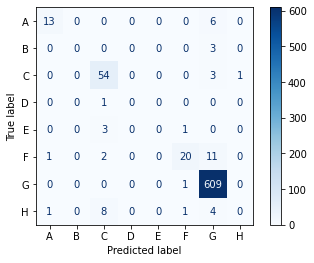

In [32]:
#this will plot true vs predicted CPC label, darker blues are higher occurrence

plot_confusion_matrix(modelSVCL,X_test_tf,
                      Y_test, values_format='d',
                      cmap=plt.cm.Blues)
plt.show()

In [33]:
#precision is a measure of how many retrieved are relevant
#precision= (true positive)/(true pos + false pos)

#recall = how many relevant items are retrieved
#recall = (true positive)/(true pos + false neg)

# f-score is a measure of function accuracy, 1 is best
#f-score is a type of mean of these functions

#the classifier works very well for G, less so for others

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           A       0.87      0.68      0.76        19
           B       0.00      0.00      0.00         3
           C       0.79      0.93      0.86        58
           D       0.00      0.00      0.00         1
           E       0.00      0.00      0.00         4
           F       0.87      0.59      0.70        34
           G       0.96      1.00      0.98       610
           H       0.00      0.00      0.00        14

    accuracy                           0.94       743
   macro avg       0.44      0.40      0.41       743
weighted avg       0.91      0.94      0.92       743



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Validation

In [34]:
# k-fold cross validation to calculate overall accruacy 
# the k-fold validation will create a sliding window of the test and train data
# essentially swap the X-train data with an average of the k-fold
tfidf = TfidfVectorizer(min_df = 2, ngram_range=(1,3), stop_words="english")
df_tf = tfidf.fit_transform(df['ClassText']).toarray()

#3 folds, higher values of K gave a warning about data sparsity

scores = cross_val_score(estimator=modelSVCL,
                         X=df_tf,
                         y=df['Main CPC Section'],
                         cv=3)

print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.92736077 0.93214863 0.93295638]
Mean value across of validation scores  0.9308219276319821
Standard deviation of validation scores  0.0024695209939204045


## Possible improvements

more Feature Exploration

Pipelining

Grid Search to compare models

# Challenge 2: Topic Modeling problem

Build a topic cluster for patents - In this challenge we will apply topic modeling which can be used to create cluster of terms.

## Import Dataset

In [35]:
#copying preprocessed dataset from above
df2=df
df2.head()

,Patent Number,Title,Abstract,Main CPC,Main CPC Section,ClassText
0,US7484245B1,system method providing data security,a system method protects security data the da...,G06F 21/6209,G,system method providing data security a system...
1,US7526762B1,network mobile terminals browsers wireless acc...,a system method provided allow user perform i...,G06F 8/33,G,network mobile terminals browsers wireless acc...
2,US7523617B2,thin film thermoelectric devices hotspot therm...,a structure system method controlling tempera...,F25B 21/02,F,thin film thermoelectric devices hotspot therm...
3,US7523191B1,system method monitoring user interaction web ...,a system monitoring usage electronic device d...,G06F 11/3495,G,system method monitoring user interaction web ...
4,US7502876B1,background memory manager determines data stru...,a background memory manager bmm managing memo...,G06F 12/023,G,background memory manager determines data stru...


## Install and import packages

In [36]:
#had to update the gensim version for colab
%pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [37]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [38]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
# from gensim.models import Nmf (wasn't able to show topics as easily with this model)
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel


## Preprocessing and exploration

In [39]:
#preprocess using spacy and extraction important features (count, n-grams, POS tags), this is a dict to remove a number of parsed POS types that spacy will recognize
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

In [40]:
#tokenize, remove stop words, remove numbers, remove POS as in dict above, lemmatize 
tokens = []
for summary in nlp.pipe(df2['ClassText']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [41]:
#add the tokenized text to the dataframe
df2['tokens']=tokens

In [42]:
#view the tokens, stop words have been removed
df2['tokens']

0       [system, method, provide, datum, security, sys...
1       [network, mobile, terminal, browser, wireless,...
2       [thin, film, thermoelectric, devices, hotspot,...
3       [system, method, monitor, user, interaction, w...
4       [background, memory, manager, determine, data,...
                              ...                        
3755    [system, method, analyze, crosstalk, occur, se...
3756    [datum, management, system, image, form, appar...
3757    [refrigerate, machine, refrigerate, machine, e...
3758    [dynamic, mouse, tray, mouse, tray, apparatus,...
3759    [installation, method, produce, cold, reversib...
Name: tokens, Length: 3715, dtype: object

In [52]:
#taking a look at the result of preprocessing and tokenization
df2.head()

,Patent Number,Title,Abstract,Main CPC,Main CPC Section,ClassText,tokens
0,US7484245B1,system method providing data security,a system method protects security data the da...,G06F 21/6209,G,system method providing data security a system...,"[system, method, provide, datum, security, sys..."
1,US7526762B1,network mobile terminals browsers wireless acc...,a system method provided allow user perform i...,G06F 8/33,G,network mobile terminals browsers wireless acc...,"[network, mobile, terminal, browser, wireless,..."
2,US7523617B2,thin film thermoelectric devices hotspot therm...,a structure system method controlling tempera...,F25B 21/02,F,thin film thermoelectric devices hotspot therm...,"[thin, film, thermoelectric, devices, hotspot,..."
3,US7523191B1,system method monitoring user interaction web ...,a system monitoring usage electronic device d...,G06F 11/3495,G,system method monitoring user interaction web ...,"[system, method, monitor, user, interaction, w..."
4,US7502876B1,background memory manager determines data stru...,a background memory manager bmm managing memo...,G06F 12/023,G,background memory manager determines data stru...,"[background, memory, manager, determine, data,..."


In [53]:
df2.describe()

,Patent Number,Title,Abstract,Main CPC,Main CPC Section,ClassText,tokens
count,3715,3715,3715,3715,3715,3715,3715
unique,3715,3660,3690,1370,8,3699,3698
top,US7484245B1,heat exchanger,a first software entity occupies portion line...,G06F 30/33,G,restricting memory access protect data sharing...,"[restrict, memory, access, protect, datum, sha..."
freq,1,5,3,33,3048,3,3


In [44]:
#tokens variable
token_class_text = df2['tokens']

## Latent Semantic Analysis processing and model evaluation

Gensim is a popular topic model package, so will switch from spacy to gensim functions

In [54]:
#create a gensim dictionary from the spacy created dicts, check the length of the dictionary itself
dict_gensim = Dictionary(token_class_text)
len(dict_gensim)

10447

In [47]:
#words must appear at least x times but not in more of y%
#i tried changing these but it did not improve coherence much
dict_gensim.filter_extremes(no_below=5, no_above=0.7)

In [48]:
#create a Bag of Words
#here the frequency of each word is used as a feature for our topic clustering method
corpus_gensim = [dict_gensim.doc2bow(row) for row in token_class_text]

In [51]:
#check to make sure each row df is included
len(corpus_gensim)

3715

In [49]:
#create the LSA model
#Latent Semantic Analysis
lda_gensim = LdaModel(corpus=corpus_gensim, id2word = dict_gensim, num_topics=7, alpha='auto', eval_every=1)

This function is an approximate solution to U.  

V = U x E x V*

V = Doc x Word
U = Doc x Topic
E = Topics diagonal matrix
V* = Topics x Words


U is a unitary m × m matrix, V* is an n × n matrix, and Σ is an m × n diagonal matrix containing the singular values.

In [ ]:
#show topics and weights
lda_gensim.print_topics()

In [ ]:
# a higher coherence score is better, this is not a very good result
# another model is probably a better choice, or more prep
coherence = CoherenceModel(model=lda_gensim, texts=token_class_text, dictionary=dict_gensim, coherence='c_v')
coherence_score = coherence.get_coherence()
coherence_score

## Findings and Insights

The first steps were to tokenize the text using spacy, then store the spacy results into a dict.  Next each patent (row) was treated as as document (title + abstract).  Then filtering for extremes and a a bag of words approach for the LSA function.  

The LSA model does not show a very good coherence score.  The imbalanced dataset is probably not helping, however I expected at least one topic to be non-G-class related.  

More text beyond Title+Abstract should improve the model as well.  The LSA model ran relatively quickly meaning it probably needs more data to chew on.

Other model options include LDA (mixture of topics for each document and a better viz package with pyLDAvis), or NMF (for quick clustering exploration).